In [1]:
import pandas as pd



In [2]:
# Read Excel file
csv_file = r"C:\Users\ROG\Downloads\retail_2009-2010.csv"
df = pd.read_csv(csv_file)
df

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ROG\\Downloads\\retail_2009-2010.csv'

In [ ]:
csv_file2 = 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/retail_2010-2011.csv'
df2 = pd.read_csv(csv_file2)
df2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Excel file
file_path = r"C:\Users\ROG\Desktop\2025 s1\case study\Sales By Country 0201.xlsx"  # Update with the correct path
xls = pd.ExcelFile(file_path)

# Read the data
df_09_10 = pd.read_excel(xls, sheet_name="09-10").iloc[1:, [0, 3]].rename(columns={"Unnamed: 3": "TotalSales", "2009-2010": "Country"})
df_10_11 = pd.read_excel(xls, sheet_name="10-11").iloc[:, [0, 3]]

# Convert sales to numeric
df_09_10["TotalSales"] = pd.to_numeric(df_09_10["TotalSales"], errors="coerce")
df_10_11["TotalSales"] = pd.to_numeric(df_10_11["TotalSales"], errors="coerce")

# Merge datasets on "Country"
df_merged = pd.merge(df_09_10, df_10_11, on="Country", suffixes=("_09_10", "_10_11"))

# Compute percentage change
df_merged["SalesChangePercent"] = ((df_merged["TotalSales_10_11"] - df_merged["TotalSales_09_10"]) /
                                   df_merged["TotalSales_09_10"]) * 100

# Select the top 10 countries based on 2010-2011 sales
df_top10 = df_merged.nlargest(10, "TotalSales_10_11")

# Plot settings
fig, ax1 = plt.subplots(figsize=(10, 8))

# Bar width and positions
bar_width = 0.4
x_indexes = np.arange(len(df_top10))

# Bar chart for total sales with updated colors
ax1.bar(x_indexes - bar_width/2, df_top10["TotalSales_09_10"], width=bar_width, color="#FFD9DA", label="Total Sales 09-10")
ax1.bar(x_indexes + bar_width/2, df_top10["TotalSales_10_11"], width=bar_width, color="#F4ACB7", label="Total Sales 10-11")

# Set y-axis to log scale with discrete numbers
ax1.set_yscale("log")
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

ax1.set_ylabel("Total Sales (Log Scale)")
ax1.set_xticks(x_indexes)
ax1.set_xticklabels(df_top10["Country"], rotation=45, ha="right")

# Reduce x-tick frequency on the total sales axis
ax1.yaxis.set_major_locator(plt.LogLocator(base=10.0, subs=[1.0], numticks=10))

# Line graph for percentage change with new color
ax2 = ax1.twinx()
ax2.plot(x_indexes, df_top10["SalesChangePercent"], marker="o", linestyle="--",
         color="#9D8189", linewidth=1, label="Sales Change (%)")

ax2.set_ylabel("Sales Change (%)")

# Adjust y-axis limits to be more symmetric
change_max = max(abs(df_top10["SalesChangePercent"].max()), abs(df_top10["SalesChangePercent"].min()))
ax2.set_ylim(-change_max/2, change_max*1.5)  # Make it symmetric around zero

# Remove grid lines for better alignment
ax1.grid(False)
ax2.grid(False)

# Add a single grid line only at y=0 with lower transparency
ax2.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)

# Move legend inside the graph at bottom left, properly aligned
fig.legend(loc="upper right", bbox_to_anchor=(0.91, 0.96), frameon=True, fontsize=10, ncol=1)

# Increase white space margins
plt.subplots_adjust(left=0.12, right=0.92)  # Adjust side margins

# Optimize layout
plt.tight_layout()

# Titles
plt.title("Top 10 Countries by Total Sales with Percentage Change")
plt.show()


# Create Table

In [ ]:
%%sql
CREATE TABLE SalesData10 (
    Invoice VARCHAR(50),
    StockCode VARCHAR(50),
    Description TEXT,
    Quantity INT,
    InvoiceDate DATETIME,
    Price DECIMAL(10, 2),
    CustomerID INT,
    Country VARCHAR(100),
    TotalPrice INT 
);

In [5]:
%%sql
# load data into the database 

LOAD DATA INFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/retail_2010-2011.csv'
INTO TABLE SalesData10
FIELDS TERMINATED BY ',' 
ENCLOSED BY '"'
LINES TERMINATED BY '\n'
IGNORE 1 ROWS
(Invoice, StockCode, Description, Quantity, InvoiceDate, Price, @CustomerID, Country, TotalPrice)
SET CustomerID = IF(@CustomerID = '', 0, @CustomerID);


# Create Views

In [23]:
%%sql
# create view of filtered sales data 09-10

CREATE OR REPLACE VIEW FilteredSales AS 
SELECT * 
FROM salesdata
WHERE 
    StockCode REGEXP '^[0-9]{5}'  
    AND Invoice NOT LIKE 'C%'      
    AND Quantity > 0               
    AND Price > 0;

In [ ]:
%%sql
# create view of filtered sales data 10-11

CREATE OR REPLACE VIEW FilteredSales10 AS 
SELECT * 
FROM salesdata10
WHERE 
    StockCode REGEXP '^[0-9]{5}'  -- StockCode starts with 5 digits
    AND Invoice NOT LIKE 'C%'      -- Invoice does NOT start with "C"
    AND Quantity > 0               -- Positive Quantity
    AND Price > 0;

## 1. Top Customer

In [3]:
%%sql
# FilteredSales / FilteredSales10

SELECT 
    CustomerID, 
    COUNT(DISTINCT Invoice) AS TotalInvoice,
    SUM(Quantity) AS TotalQuantity, 
    SUM(Quantity * Price) AS TotalSales
FROM FilteredSales10
WHERE CustomerID IS NOT NULL  
AND CustomerID <> 0  -- Exclude CustomerID = 0
GROUP BY CustomerID
ORDER BY TotalSales DESC, TotalQuantity DESC;


,CustomerID,TotalInvoice,TotalQuantity,TotalSales
0,14646,72,393688,558276.04
1,18102,60,128248,519314.60
2,17450,46,139986,389101.58
3,16446,2,161994,336945.00
4,14911,198,160358,272551.44
...,...,...,...,...
4329,16878,1,24,26.60
4330,17956,1,2,25.50
4331,14792,1,4,12.40
4332,16454,1,4,11.80


## 2. By Country

In [4]:
%%sql
# By Country

SELECT country,
    COUNT(DISTINCT Invoice) AS TotalInvoice,
    SUM(Quantity) AS TotalQuantity, 
    SUM(Quantity * Price) AS TotalSales
FROM FilteredSales
GROUP BY country
ORDER BY TotalQuantity desc ;


,Country,TotalInvoice,TotalQuantity,TotalSales
0,United Kingdom,19053,4716698,8485552.48
1,Denmark,25,229659,50348.85
2,EIRE,309,192983,357764.33
3,Netherlands,124,183464,266063.32
4,France,227,162664,132366.06
5,Germany,325,107739,183259.86
6,Sweden,65,52512,49513.71
7,Spain,58,22754,42887.68
8,Switzerland,36,22205,41182.39
9,Australia,35,20184,30313.35


## 4. Time Series

In [13]:
%%sql
SELECT 
    DATE(InvoiceDate) AS SaleDate, 
    COUNT(DISTINCT Invoice) AS TotalTransactions, 
    SUM(Quantity) AS TotalQuantity, 
    SUM(Quantity * Price) AS TotalSales 

FROM FilteredSales
GROUP BY SaleDate
ORDER BY SaleDate;


,SaleDate,TotalTransactions,TotalQuantity,TotalSales
0,2009-12-01,117,26174,52591.40
1,2009-12-02,115,31891,62053.03
2,2009-12-03,124,49238,73090.58
3,2009-12-04,88,21307,39499.81
4,2009-12-05,30,5119,9803.05
...,...,...,...,...
302,2010-12-05,88,16371,31318.99
303,2010-12-06,102,21768,51873.43
304,2010-12-07,82,25200,81519.34
305,2010-12-08,116,23066,44308.60


In [6]:
%%sql
SELECT * 
FROM salesdata10
WHERE 
    StockCode REGEXP '^[0-9]{5}'  -- StockCode starts with 5 digits
    AND Invoice not LIKE 'C%'      -- Invoice does NOT start with "C"
    AND Quantity > 0              -- Positive Quantity
    AND Price > 0;



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20
...,...,...,...,...,...,...,...,...,...
1055445,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10
1055446,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,13
1055447,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,17
1055448,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,17


In [7]:
%%sql
WITH purchase_counts AS (
    SELECT 
        CustomerID,
        COUNT(DISTINCT Invoice) AS purchase_count
    FROM salesdata
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID
)
SELECT 
    purchase_count,
    COUNT(CustomerID) AS customer_count
FROM purchase_counts
GROUP BY purchase_count
ORDER BY purchase_count;

,purchase_count,customer_count
0,1,1267
1,2,773
2,3,486
3,4,383
4,5,256
...,...,...
65,138,1
66,158,2
67,159,1
68,270,1


In [8]:
%%sql


Exception: [S1009] Can not issue empty query.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

# Convert 'SaleDate' to datetime (if not already)
df_sql5["SaleDate"] = pd.to_datetime(df_sql5["SaleDate"])

# Set figure size
plt.figure(figsize=(12, 6))

# Line plot
sns.lineplot(data=df_sql5, x="SaleDate", y="TotalSales", marker="o")

# Format X-axis to show **monthly** ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks = start of each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format as "Jan 2024", "Feb 2024", etc.

# Labels and title
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Daily Sales Trend Over Time")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure size
plt.figure(figsize=(12, 6))

# Line plot
sns.lineplot(data=df_sql4, x="purchase_count", y="customer_count", marker="o")

# Set X-axis to logarithmic scale
plt.xscale("log")

# Generate integer tick marks for X-axis
ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
plt.xticks(ticks, [str(tick) for tick in ticks])  # Force integer labels

# Labels and title
plt.xlabel("Purchase Count (Log Scale)")
plt.ylabel("Customer Count")
plt.title("Customer Count vs Purchase Count (Log Scale)")

# Show the plot
plt.show()


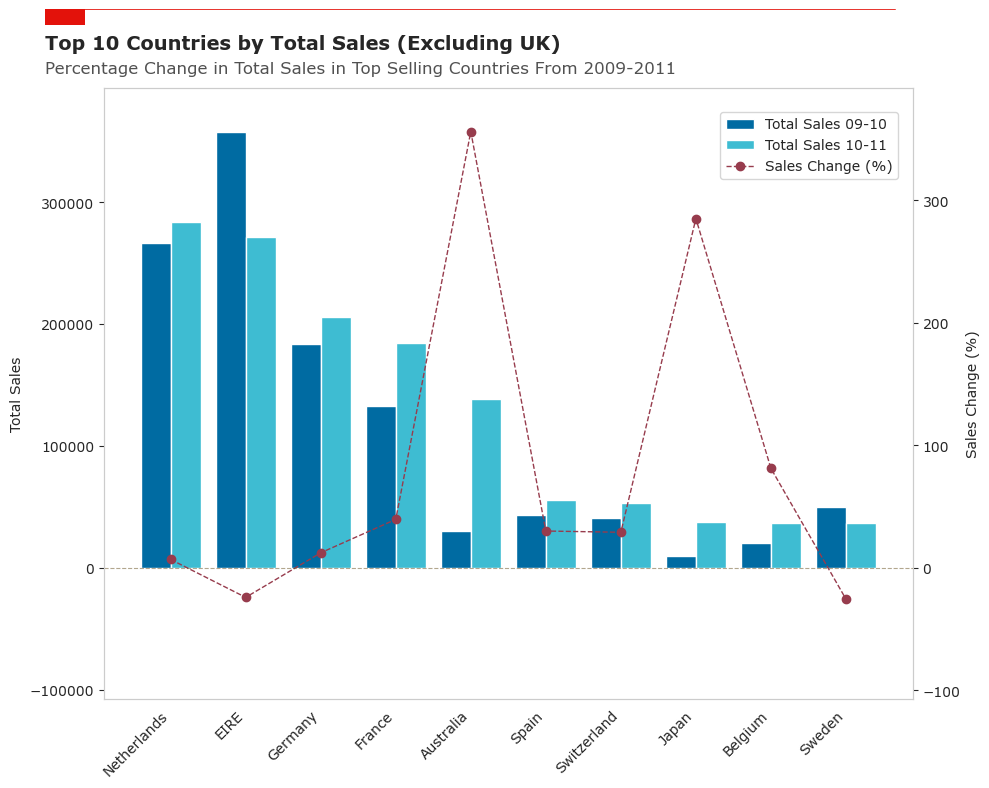

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set font to Noto Sans TC for proper Chinese display
plt.rcParams['font.sans-serif'] = ['Verdana']

# Load Excel file
file_path = r"C:\Users\ROG\Desktop\2025 s1\case study\Sales By Country 0201.xlsx"
xls = pd.ExcelFile(file_path)

# Read the data
df_09_10 = pd.read_excel(xls, sheet_name="09-10").iloc[1:, [0, 3]].rename(columns={"Unnamed: 3": "TotalSales", "2009-2010": "Country"})
df_10_11 = pd.read_excel(xls, sheet_name="10-11").iloc[:, [0, 3]]

# Convert sales to numeric
df_09_10["TotalSales"] = pd.to_numeric(df_09_10["TotalSales"], errors="coerce")
df_10_11["TotalSales"] = pd.to_numeric(df_10_11["TotalSales"], errors="coerce")

# Merge datasets on "Country"
df_merged = pd.merge(df_09_10, df_10_11, on="Country", suffixes=("_09_10", "_10_11"))

# Compute percentage change
df_merged["SalesChangePercent"] = ((df_merged["TotalSales_10_11"] - df_merged["TotalSales_09_10"]) /
                                   df_merged["TotalSales_09_10"]) * 100

# Remove the UK from the dataset
df_merged = df_merged[df_merged["Country"] != "United Kingdom"]

# Select the top 10 countries based on 2010-2011 sales
df_top10 = df_merged.nlargest(10, "TotalSales_10_11")

# Plot settings
fig, ax1 = plt.subplots(figsize=(10, 8))

# Bar width and positions
bar_width = 0.4
x_indexes = np.arange(len(df_top10))

# Get the maximum sales value for top 10
max_sales_top10 = max(df_top10["TotalSales_09_10"].max(), df_top10["TotalSales_10_11"].max())

# Bar chart for total sales with updated colors
ax1.bar(x_indexes - bar_width/2, df_top10["TotalSales_09_10"], width=bar_width, color="#006BA2",
        label="Total Sales 09-10")
ax1.bar(x_indexes + bar_width/2, df_top10["TotalSales_10_11"], width=bar_width, color="#3EBCD2",
        label="Total Sales 10-11")

# Set y-axis limits to have 0 in the middle
ax1.set_ylim(-max_sales_top10 * 0.3, max_sales_top10 * 1.1)  # Negative space is 10% of max, positive space is 110% of max

ax1.set_ylabel("Total Sales")
ax1.set_xticks(x_indexes)
ax1.set_xticklabels(df_top10["Country"], rotation=45, ha="right")

# Line graph for percentage change with new colo=[]---[-[
ax2 = ax1.twinx()
ax2.plot(x_indexes, df_top10["SalesChangePercent"], marker="o", linestyle="--",
         color="#973C4D", linewidth=1, label="Sales Change (%)")

# Calculate percentage axis limits with padding
percent_max = max(abs(df_top10["SalesChangePercent"].max()), abs(df_top10["SalesChangePercent"].min()))
# padding_factor = 1.2  # 20% padding
ax2.set_ylim(-percent_max * 0.3, percent_max * 1.1)

ax2.set_ylabel("Sales Change (%)")

# Remove grid lines for better alignment
ax1.grid(False)
ax2.grid(False)

ax1.plot([0.05, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax1.add_patch(plt.Rectangle((0.05, .98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth=0))
ax1.text(x=0.05, y=.93, s="Top 10 Countries by Total Sales (Excluding UK)", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=1)
ax1.text(x=0.05, y=.90, s="Percentage Change in Total Sales in Top Selling Countries From 2009-2011", transform=fig.transFigure, ha='left', fontsize=12, alpha=0.8)

# Add a single grid line at y=0 with lower transparency
ax2.axhline(y=0, color="#674E1F", linestyle="--", linewidth=0.8, alpha=0.5)

# Move legend inside the graph at bottom left, properly aligned
fig.legend(loc="upper right", bbox_to_anchor=(0.91, 0.86), frameon=True, fontsize=10, ncol=1)

# Increase white space margins
plt.subplots_adjust(left=0.12, right=0.92)

# Optimize layout
plt.tight_layout()

plt.show()

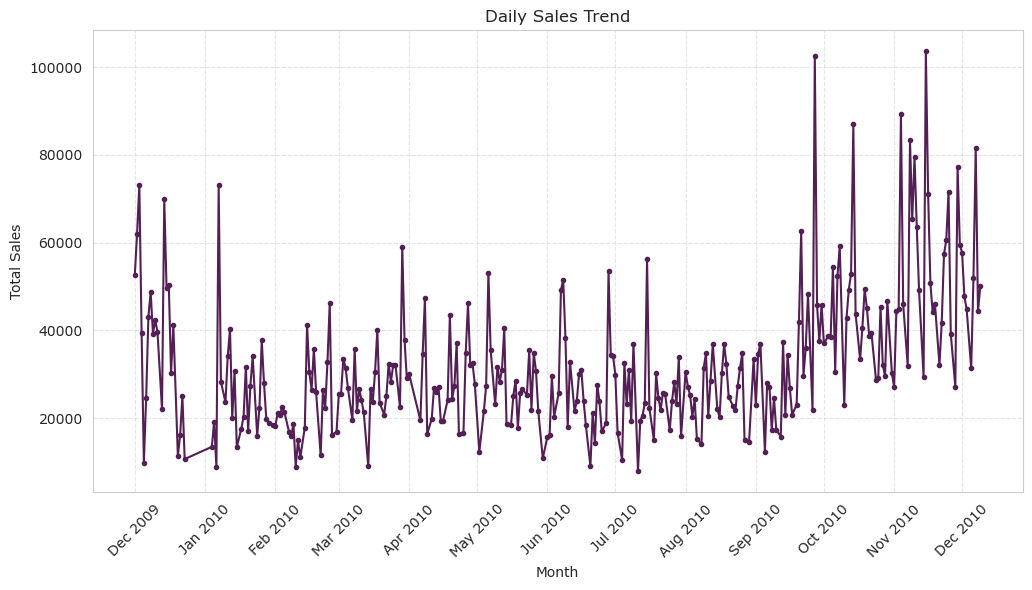

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure SaleDate is in datetime format
df_sql5["SaleDate"] = pd.to_datetime(df_sql5["SaleDate"])

# Sort data by date
df_sql5 = df_sql5.sort_values(by="SaleDate")

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_sql5["SaleDate"], df_sql5["TotalSales"], linestyle="-", marker="o", markersize=3, color="#531F55")

# Formatting the plot
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Daily Sales Trend")
plt.grid(True, linestyle="--", alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Change x-axis to display months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format as "Jan 2024", "Feb 2024", etc.

# Increase y-ticks
plt.yticks(fontsize=10)  # Adjust y-tick frequency

# Show the plot
plt.show()
